In [98]:
import pandas as pd
import requests
from datetime import datetime
from sqlalchemy import create_engine
import os
uri = os.environ.get('URI')


url = 'https://api.blockchain.info/charts/transactions-per-second?timespan=all&sampled=false&metadata=false&cors=true&format=json'

resp = requests.get(url)


In [99]:
data = pd.DataFrame(resp.json()["values"])

In [100]:
# from timestamp to date
data['x'] = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in data['x']]
data['x'] = pd.to_datetime(data['x'])

In [101]:
data.head()

,x,y
0,2016-06-11 00:00:00,1.983333
1,2016-06-11 00:15:00,1.966667
2,2016-06-11 00:30:00,1.900000
3,2016-06-11 00:45:00,2.283333
4,2016-06-11 01:00:00,2.083333


In [102]:
data.columns = ["date", "transactions"]

In [103]:
data.head()

,date,transactions
0,2016-06-11 00:00:00,1.983333
1,2016-06-11 00:15:00,1.966667
2,2016-06-11 00:30:00,1.900000
3,2016-06-11 00:45:00,2.283333
4,2016-06-11 01:00:00,2.083333


In [104]:
data['date'] = data['date'].dt.round('H')
grouped_data = data.groupby('date').sum().reset_index()


In [105]:
grouped_data.head()

,date,transactions
0,2016-06-11 00:00:00,5.85
1,2016-06-11 01:00:00,6.05
2,2016-06-11 02:00:00,9.05
3,2016-06-11 03:00:00,6.05
4,2016-06-11 04:00:00,12.65


In [106]:
# switched from DataFrame to pandas.series (which is just one/each column of dataframe)
grouped_data = grouped_data.set_index('date')
grouped_data = grouped_data['transactions']
grouped_data.head()

date
2016-06-11 00:00:00     5.85
2016-06-11 01:00:00     6.05
2016-06-11 02:00:00     9.05
2016-06-11 03:00:00     6.05
2016-06-11 04:00:00    12.65
Name: transactions, dtype: float64

In [107]:
type(grouped_data)

pandas.core.series.Series

In [108]:
steps = 36
n_datos_entrenar = 200

train_data = grouped_data[ -n_datos_entrenar:-steps]
test_data  = grouped_data[-steps:]

In [140]:
print(train_data.shape)
train_data.head()

(164,)


date
2024-04-02 05:00:00    15.800000
2024-04-02 06:00:00    17.283333
2024-04-02 07:00:00     9.100000
2024-04-02 08:00:00    19.366667
2024-04-02 09:00:00    13.216667
Name: transactions, dtype: float64

In [123]:
#from utils import create_predictors
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 

# imports for data reading
import requests
from datetime import datetime

# imports for Neptune
import os
from dotenv import load_dotenv
import neptune

#### Zwykły fit, bez opcji z param_grid() - nie będzie optymalny

In [136]:
# Define forecaster
forecaster_rf = ForecasterAutoreg(
                    regressor      = RandomForestRegressor(random_state=123),
                    #fun_predictors = create_predictors,
                    lags    = 20
                )

In [144]:
forecaster_rf.fit(y=train_data)
forecaster_rf

/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 163] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-04-10 15:22:43 
Last fit date: 2024-04-10 15:29:18 
Skforecast version: 0.11.0 
Python version: 3.10.

steps = 36
predictions = forecaster_rf.predict(steps=steps)
predictions.head(5)

In [111]:
param_grid = { 'n_estimators': [100, 500], 'max_depth': [3, 5, 10] }

In [120]:
test_data.head()

date
2024-04-09 01:00:00     8.283333
2024-04-09 02:00:00    20.733333
2024-04-09 03:00:00    20.400000
2024-04-09 04:00:00    18.016667
2024-04-09 05:00:00    10.116667
Name: transactions, dtype: float64

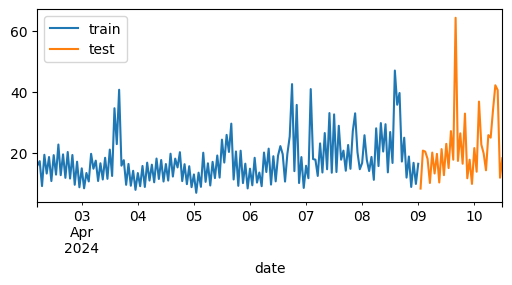

In [132]:
fig, ax = plt.subplots(figsize=(6, 2.5))
train_data.plot(ax=ax, label='train')
test_data.plot(ax=ax, label='test')
#predictions.plot(ax=ax, label='predictions')
ax.legend();

In [138]:
grid_results = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = train_data,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(train_data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True, # return only ONE best grid
                        verbose     = False
                    )

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten wi

KeyError: "None of [Index([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 20, 21, 22, 23, 24, 25, 26, 27,\n       28, 29, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 20, 21, 22, 23, 24, 25,\n       26, 27, 28, 29, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 20, 21, 22, 23,\n       24, 25, 26, 27, 28, 29, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 20, 21,\n       22, 23, 24, 25, 26, 27, 28, 29, 20, 21],\n      dtype='int64')] are in the [index]"